## Final Project Submission

Please fill out:
* Student name: Filip Szafranski
* Student pace: self paced
* Scheduled project review date/time: 5/11/2021
* Instructor name: Jeff Herman
* Blog post URL: https://www.linkedin.com/pulse/draft/AgGC8QrqFW_bzgAAAXlYvcpmExEgwSRwlO-ahFY82koUqxdvdT-uIOksWFv52q348Fmq76Q

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

### Load the previously cleaned and processed data with Pickle

In [4]:
with open('df_processed.pickle', 'rb') as f:
    df = pickle.load(f)

### Data Overview

In [5]:
df.head(10)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1,98125,47.7210,-122.319,1690,7639
2,2015,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2014,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2015,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,2014,1230000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,2014,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2015,291850.0,3,1.50,1060,9711,1.0,0,2,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2015,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,2015,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


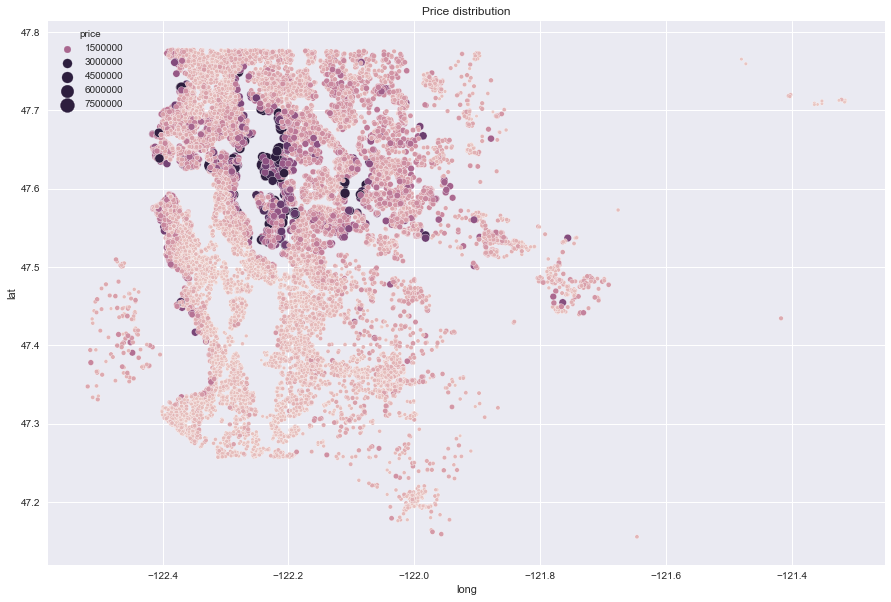

In [6]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=df, 
                x="long", 
                y="lat", 
                hue="price",
                hue_norm=(0, 3000000),
                size='price', 
                sizes=(10, 200))
ax.set_title('Price distribution')
plt.savefig('viz/price_distribution_scatter.png', bbox_inches="tight")

### Feature Engineering
- add 'has_basement" parameter
- add distance from Seatlle and Bellevue based on GPS coordinates
- categorize zipecodes based on the price 

In [7]:
#Adding has_basement parameter - 1 where basement area > 0 
df['has_basement'] = (df['sqft_basement'] > 0).astype(int)

In [8]:
#Dropping sqft_basement column
df.drop(columns='sqft_basement', inplace=True)

In [9]:
#Adding distance from epicenter using Haversine library
from haversine import haversine, Unit

epicenter = [47.60558637885264, -122.25954856134759]

df['dist_epicenter'] = df.apply(lambda x:haversine(epicenter, [x['lat'],x['long']] , unit='km'), axis=1)

In [10]:
#categoize zipcodes by median house price
zip_cat_df = df.groupby(by='zipcode')['price'].mean().sort_values(ascending=False).reset_index()
zip_cat_df['zip_price_cat'] = pd.cut(zip_cat_df['price'], bins=5, labels=False) + 1
zip_cat_df

,zipcode,price,zip_price_cat
0,98039,2.186224e+06,5
1,98004,1.355200e+06,3
2,98040,1.194874e+06,3
3,98112,1.096523e+06,3
4,98102,8.996077e+05,2
...,...,...,...
65,98148,2.820498e+05,1
66,98001,2.813837e+05,1
67,98032,2.511958e+05,1
68,98168,2.413308e+05,1


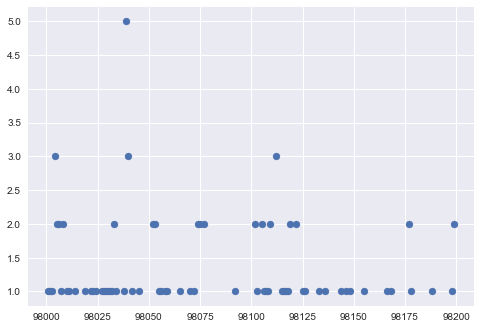

In [11]:
plt.scatter(zip_cat_df.zipcode, zip_cat_df.zip_price_cat)

In [ ]:
#Merge categories with df
df = df.merge(zip_cat_df.drop(columns='price'), how='left', on='zipcode')

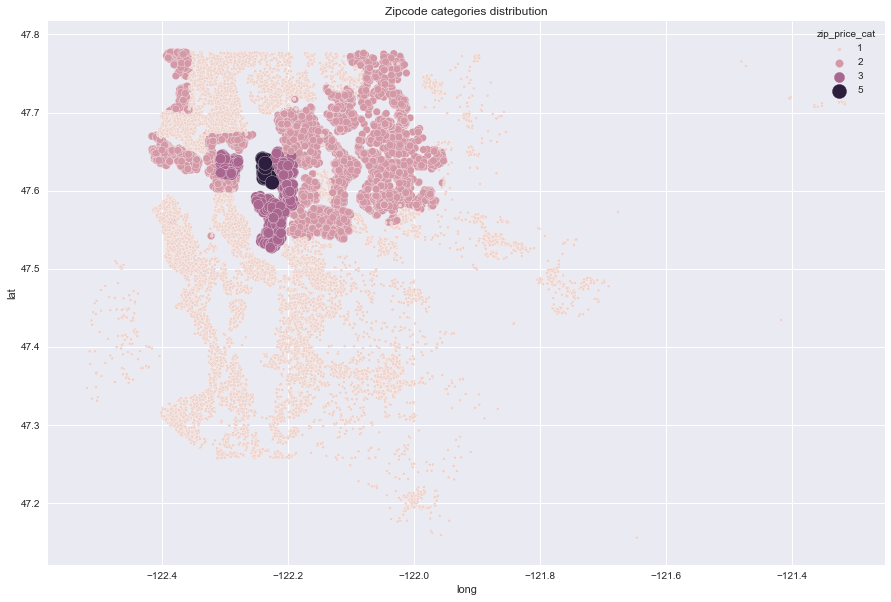

In [14]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=df, 
                x="long", 
                y="lat", 
                hue="zip_price_cat",
                size='zip_price_cat', 
                sizes=(10, 200))
ax.set_title('Zipcode categories distribution')
plt.savefig('viz/zipcode_distribution_scatter.png', bbox_inches="tight")

### Exploratory Data Analysis — (EDA)

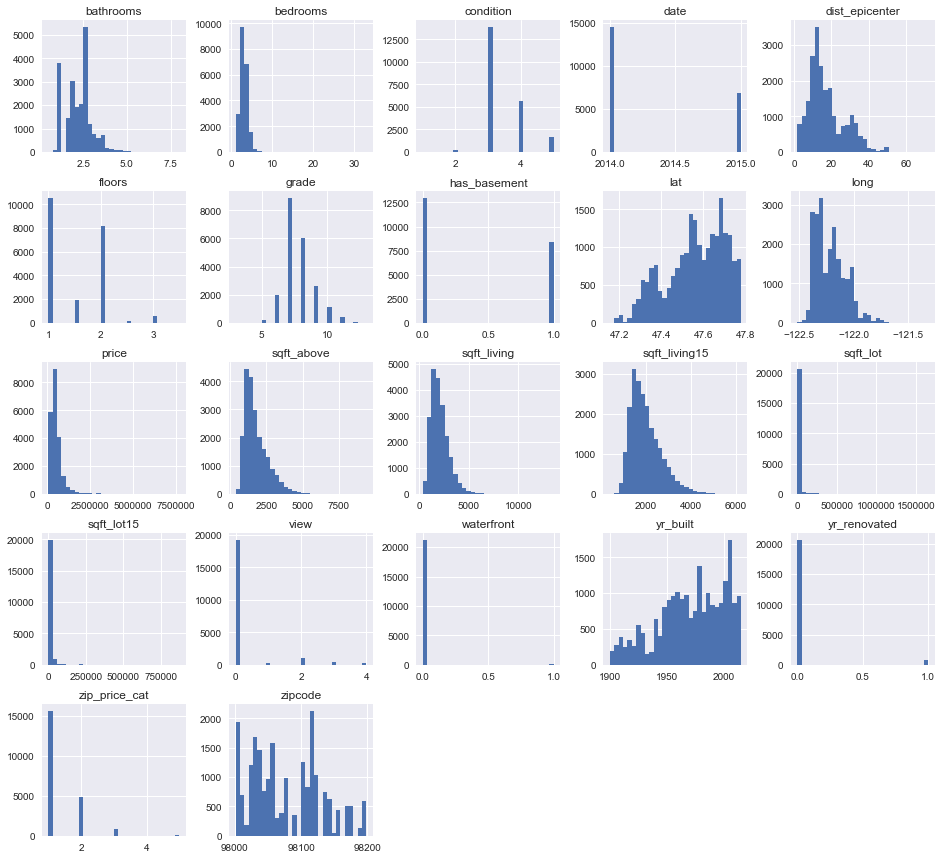

In [12]:
df.hist(figsize = (16,15), bins=30);

### Check the linearity assumption for all chosen features with target variable using scatter plots

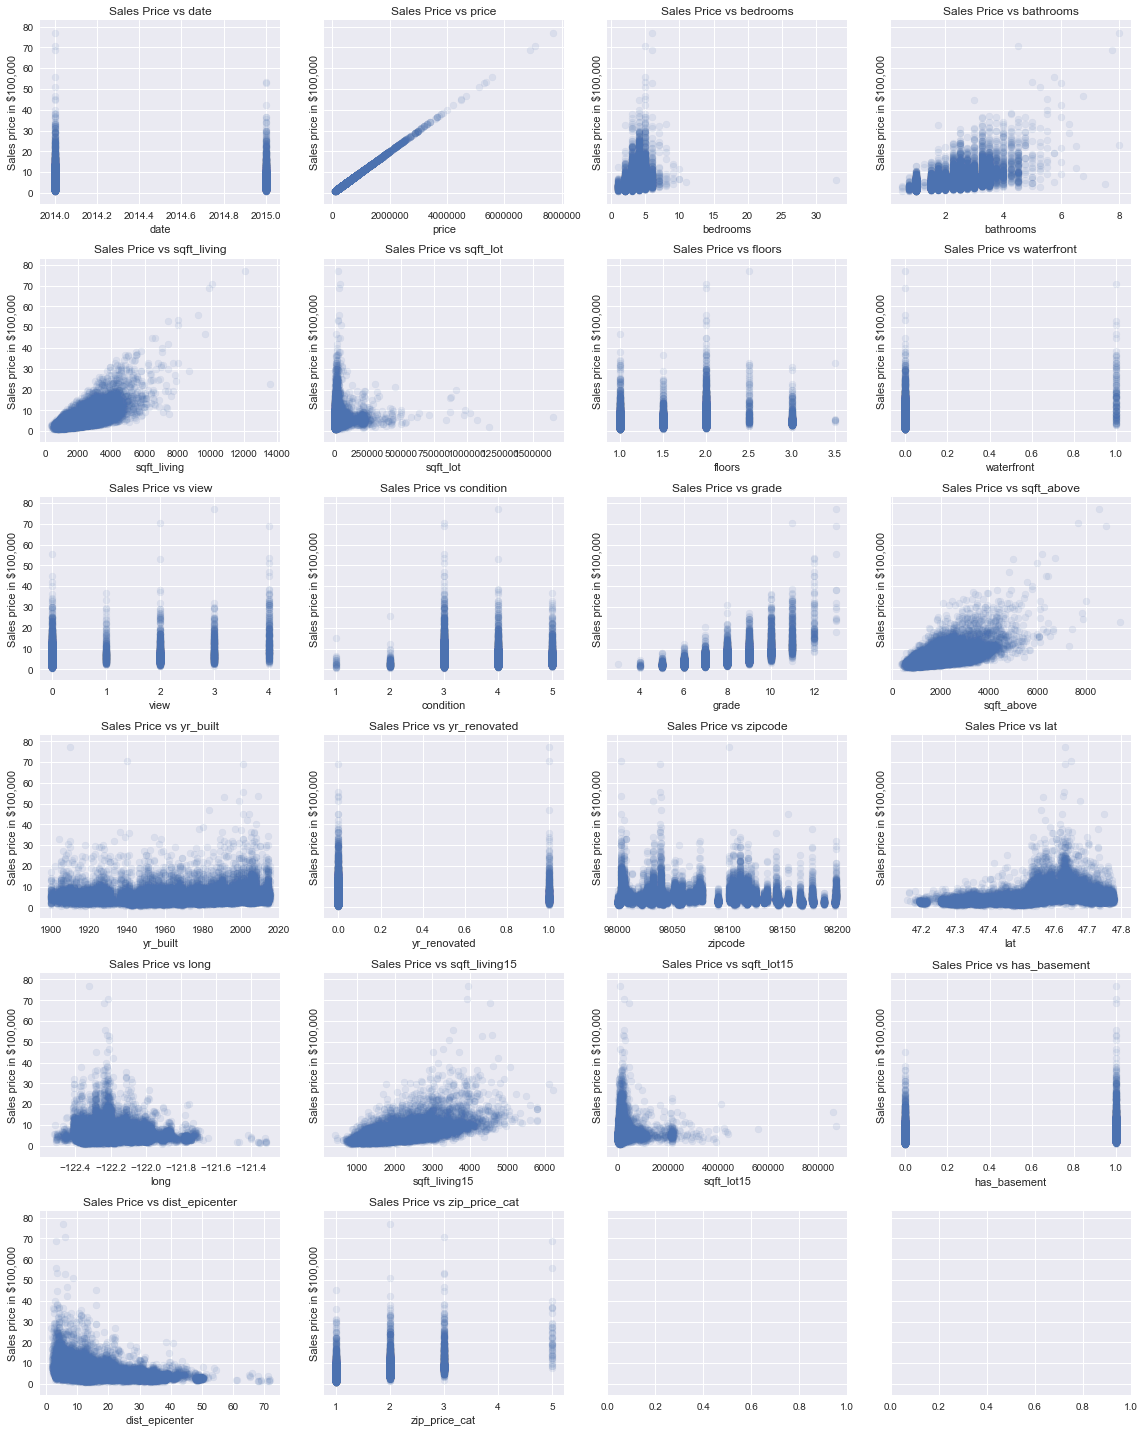

In [13]:
fig, axes = plt.subplots(nrows = 6, ncols= 4, figsize=(16,20), sharey=True)

for ax, column in zip(axes.flatten(), df.columns):
    ax.scatter(df[column], df['price']/100_000, label = column, alpha= .1)
    ax.set_title(f'Sales Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sales price in $100,000')
    
fig.tight_layout()

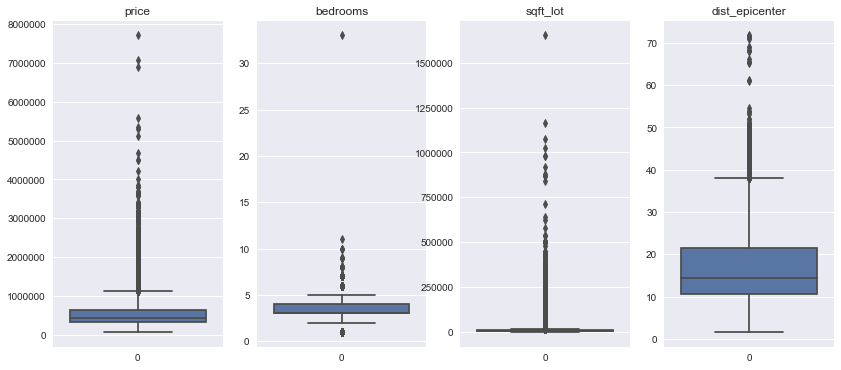

In [15]:
#Checking for outliers using Seaborn boxplots
fig, axs = plt.subplots(ncols=4, figsize = (14,6))
sns.boxplot(data=df['price'], orient='v', ax=axs[0])
axs[0].set_title('price')
sns.boxplot(data=df['bedrooms'], orient='v', ax=axs[1])
axs[1].set_title('bedrooms')
sns.boxplot(data=df['sqft_lot'], orient='v', ax=axs[2])
axs[2].set_title('sqft_lot')
sns.boxplot(data=df['dist_epicenter'], orient='v', ax=axs[3])
axs[3].set_title('dist_epicenter')
plt.savefig('viz/outliers_boxplot.png', bbox_inches="tight")

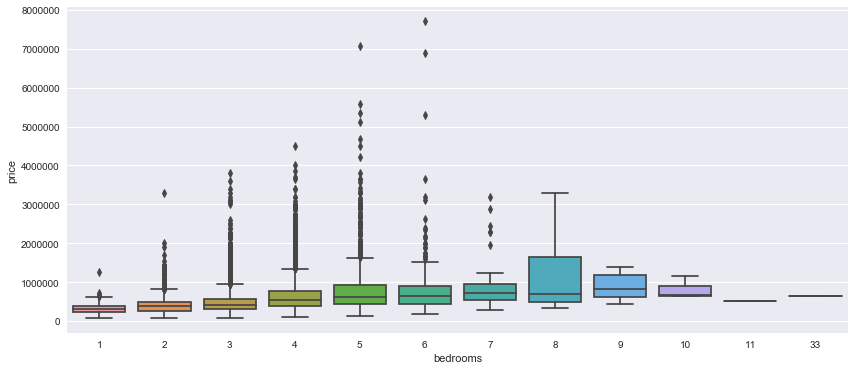

In [16]:
#Bedrooms distribution by price
plt.figure(figsize=(14,6))
sns.boxplot(x="bedrooms", y="price", data=df)

cols = ['bedrooms'] # one or more

Q1 = df[cols].quantile(0.02)
Q3 = df[cols].quantile(0.98)
IQR = Q3 - Q1

df_outliers = df[((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
df_outliers.index
plt.savefig('viz/bedrooms_boxplot.png', bbox_inches="tight")

In [897]:
df[df['price']>6*10**6]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_basement,dist_seatlle,dist_bellevue,zip_price_cat
3877,2014,7060000.0,5,4.50,10040,37325,2.0,1,2,3,...,1,98004,47.6500,-122.214,3930,25449,1,10.101861,4.534487,3
7187,2014,7700000.0,6,8.00,12050,27600,2.5,0,3,4,...,1,98102,47.6298,-122.323,3940,8800,1,2.711397,9.366246,2
9170,2014,6890000.0,6,7.75,9890,31374,2.0,0,4,3,...,0,98039,47.6305,-122.240,4540,42730,1,7.413133,3.670435,5


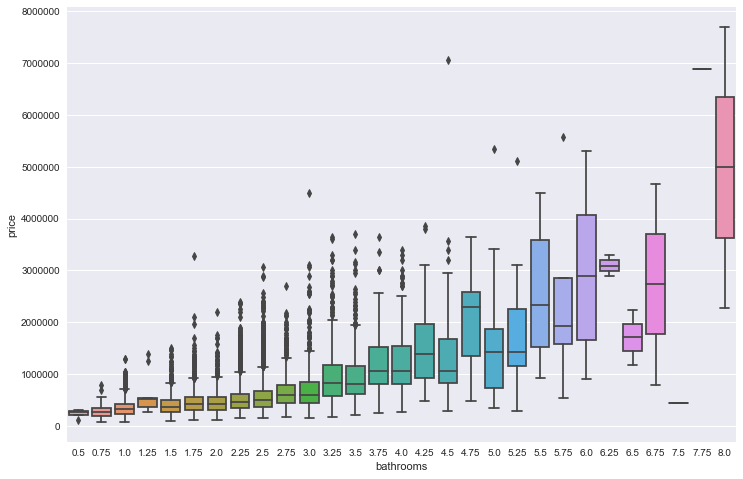

In [838]:
#Bathrooms distribution by price
plt.figure(figsize=(12,8))
sns.boxplot(x="bathrooms", y="price", data=df)

### Feature Engineering - is_residential parameter

In [17]:
#Analizing sqft_above/sqft_lot ratio and assigning is_residnetial coefficent
df['above_lot_ratio'] = df.apply(lambda x: round(x['sqft_lot']/x['sqft_above'], 2), axis=1)
df['above_lot_ratio'].sort_values(ascending=False).head(20)

17150    1640.55
1702     1270.28
17405     667.01
7582      534.44
17650     475.72
2845      470.93
13496     444.22
2934      384.16
4401      383.70
13692     362.28
14807     351.67
7229      344.02
8529      325.02
12792     320.91
9127      318.20
12877     304.55
3462      294.63
13345     281.23
18660     281.03
2938      276.05
Name: above_lot_ratio, dtype: float64

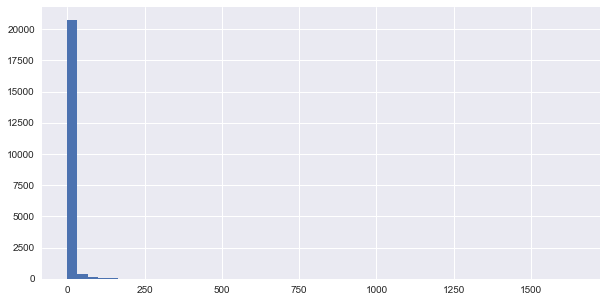

In [11]:
df['above_lot_ratio'].hist(bins=50, figsize=(10,5))

In [18]:
#Binarize is_residential provided above_lot_ratio is below 10
df['is_residential'] = (df['above_lot_ratio'] < 10).astype(int)

In [19]:
#New features summary
df[['is_residential', 'has_basement', 'dist_epicenter', 'above_lot_ratio']].head()

,is_residential,has_basement,dist_epicenter,above_lot_ratio
0,1,0,10.497043,4.79
1,1,1,13.583780,3.34
2,0,0,14.846308,12.99
3,1,1,13.753042,4.76
4,1,0,16.131475,4.81


### Identifying continous variables

In [20]:
subset_cont = ['price', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15','dist_epicenter']

### Identifying multicollinearity

In [15]:
abs(df.corr())>0.75

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,has_basement,dist_epicenter,zip_price_cat,above_lot_ratio,is_residential
date,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
floors,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


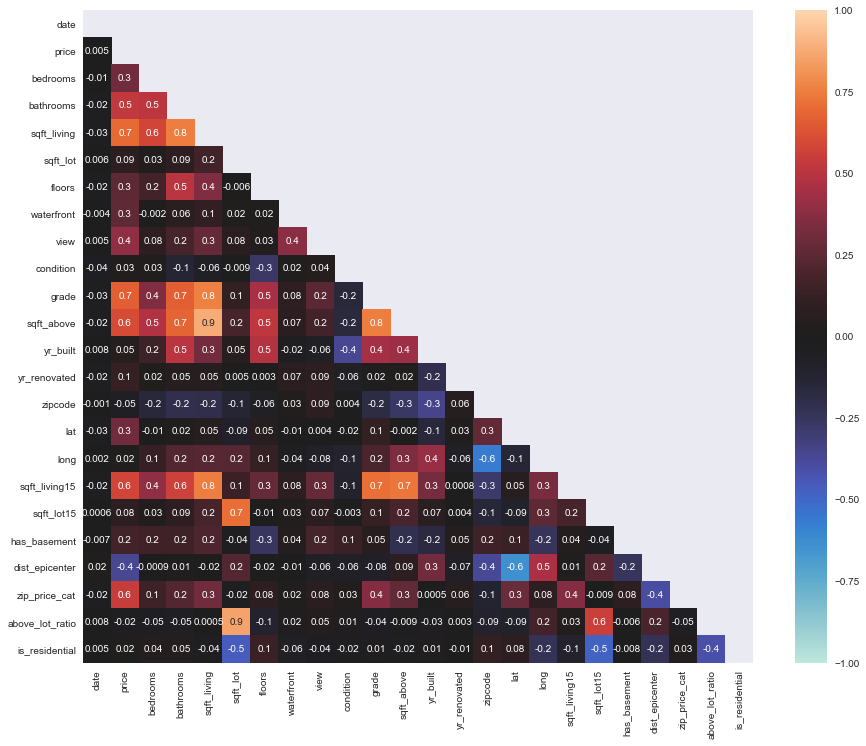

In [16]:
plt.figure(figsize=(15,12))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), center=0, annot=True, fmt='.1g', vmin=-1, vmax=1, mask=matrix)

In [21]:
df_corr=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

# set index to pairs
df_corr.set_index(['pairs'], inplace = True)

#d rop level columns
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_corr.drop_duplicates(inplace=True)


In [22]:
df_corr[(df_corr.cc>0.75) & (df_corr.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876533
"(sqft_lot, above_lot_ratio)",0.854792
"(sqft_living, grade)",0.762477
"(sqft_above, grade)",0.756221
"(sqft_living15, sqft_living)",0.756186
"(bathrooms, sqft_living)",0.755522


In [23]:
#Dropping highly coorelated columns
df.drop(columns=['sqft_living','grade','above_lot_ratio'], inplace=True)

###  Log Transformations

In [24]:
#Drop sqft_lot outliers

cols = ['price', 'sqft_lot', 'bedrooms', 'dist_epicenter'] # one or more

Q1 = df[cols].quantile(0.01)
Q3 = df[cols].quantile(0.99)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

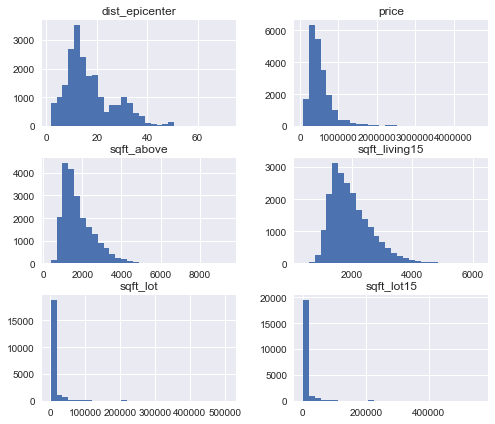

In [25]:
df[subset_cont].hist(figsize = (8,7),bins=30);

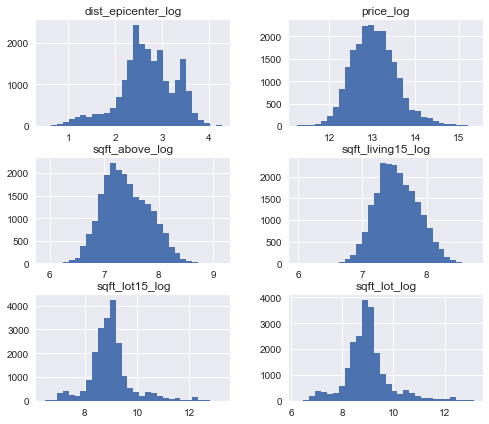

In [26]:
#Log transform and normalize
df_cont = df[subset_cont]

#Log features
log_names = [f'{column}_log' for column in df_cont.columns]
df_log = np.log(df_cont)
df_log.columns = log_names

df_log.hist(figsize = (8,7), bins=30);

### ONE-HOT ENCODING

In [187]:
# df_ohe = pd.get_dummies(df[subset_cat], prefix=subset_cat, columns=subset_cat, drop_first=True)

In [29]:
# df_ohe.head().T

### MODEL FIT WITH STATSMODEL

In [27]:
df_preprocessed = pd.concat([df, df_log], axis=1)
df_preprocessed.drop(['price', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
df_preprocessed

,date,bedrooms,bathrooms,floors,waterfront,view,condition,yr_built,yr_renovated,zipcode,...,has_basement,dist_epicenter,zip_price_cat,is_residential,price_log,sqft_lot_log,sqft_above_log,sqft_living15_log,sqft_lot15_log,dist_epicenter_log
0,2014,3,1.00,1.0,0,0,3,1955,0,98178,...,0,10.497043,1,1,12.309982,8.639411,7.073270,7.200425,8.639411,2.351094
1,2014,3,2.25,2.0,0,0,3,1951,1,98125,...,1,13.583780,1,1,13.195614,8.887653,7.682482,7.432484,8.941022,2.608876
2,2015,2,1.00,1.0,0,0,3,1933,0,98028,...,0,14.846308,1,0,12.100712,9.210340,6.646391,7.908387,8.994917,2.697751
3,2014,4,3.00,1.0,0,0,5,1965,0,98136,...,1,13.753042,1,1,13.311329,8.517193,6.956545,7.215240,8.517193,2.621260
4,2015,3,2.00,1.0,0,0,3,1987,0,98074,...,0,16.131475,2,1,13.142166,8.997147,7.426549,7.495542,8.923058,2.780772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,2014,3,2.50,3.0,0,0,3,2009,0,98103,...,0,12.268635,1,1,12.793859,7.030857,7.333023,7.333023,7.319202,2.507046
21416,2015,4,2.50,2.0,0,0,3,2014,0,98146,...,0,13.054677,1,1,12.899220,8.667852,7.745003,7.512071,8.881836,2.569146
21417,2014,2,0.75,2.0,0,0,3,2009,0,98144,...,0,3.208922,1,1,12.904459,7.207860,6.927558,6.927558,7.604396,1.165935
21418,2015,3,2.50,2.0,0,0,3,2004,0,98027,...,0,16.335144,1,1,12.899220,7.778211,7.377759,7.251345,7.160069,2.793319


In [31]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [28]:
predictors = [
 'has_basement',
 'zip_price_cat',
 'sqft_above_log',
 'bedrooms',
 'waterfront',
 'dist_epicenter_log',
]

# predictors = ['date', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
#        'condition', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
#        'has_basement', 'dist_seatlle', 'zip_price_cat', 'is_residential',
#         'sqft_lot_log', 'sqft_above_log', 'sqft_living15_log',
#        'sqft_lot15_log', 'dist_seatlle_log']


In [33]:
X= df_preprocessed[predictors]
y= df_preprocessed['price_log']
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     9035.
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        17:09:53   Log-Likelihood:                -3047.1
No. Observations:               21395   AIC:                             6108.
Df Residuals:                   21388   BIC:                             6164.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.6701      0.039    196.885      0.000       7.594       7.746
has_basement           0.2757      0.004     63.032      0.000       0.267       0.284
zip_price_cat          0.1953      0.004     47.813      0.000       0.187       0.203
sqft_above_log         0.8130      0.006    136.061      0.000       0.801       0.825
bedrooms              -0.0429      0.003    -16.161      0.000      -0.048      -0.038
waterfront             0.7267      0.024     30.889      0.000       0.681       0.773
dist_epicenter_log    -0.3209      0.004    -82.955      0.000      -0.329      -0.313
==============================================================================
Omnibus:                      211.822   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.015
Skew:                          -0.080   Prob(JB):                     8.01e-73
Kurtosis:                       3.589   Cond. No.                         181.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretaion of coefficients

In [179]:
#sqft_living vs. price - a 10% increase in square_above leads to a 8% increase in price

round(1.1**0.81, 2)
#1.08

In [184]:
#dist_epicenter vs. price - a 10% increase in distance from the epicenter leads to a 3% decrease in price

round(1.1**-0.32, 2)
#0.97 which means a 3% distance increase (1-0.97)

In [191]:
#waterfront vs. price - the price of the house increases by 107% if waterfront equals 1
round(np.expm1(0.726), 2)
#1.07

1.07

In [189]:
#has_basement vs. price - the price of the house increases by 32% if the house has a basement (equals 1)
round(np.expm1(0.275), 2)
#0.32

0.32

In [192]:
#zip_price_cat vs. price - the price of the house increases by 22% when icreasing the zip code category by 1
round(np.expm1(0.1953), 2)
#0.22

0.22

In [53]:
stepwise_selection(X, y)

/Users/Filip/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  bedrooms                       with p-value 0.0
Add  dist_epicenter_log             with p-value 0.0
Add  sqft_above_log                 with p-value 0.0
Add  zip_price_cat                  with p-value 0.0
Add  has_basement                   with p-value 0.0
Add  waterfront                     with p-value 1.42444e-203


['bedrooms',
 'dist_epicenter_log',
 'sqft_above_log',
 'zip_price_cat',
 'has_basement',
 'waterfront']

In [34]:
# Split the data into training and test sets (assign 20% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

14976 6419 14976 6419


In [36]:
# Fit a linear regression model and apply the model to make predictions on test set
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [37]:
# Calculate the residuals and the mean squared error on the test set
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.07797410283056425
Test Mean Squarred Error: 0.07756944175095953


### Cross Validation

In [38]:
# Perform 5-fold cross-validation to get the mean squared error through scikit-learn
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)

In [39]:
# Calculate the mean of the MSE over the 5 cross-validation and compare and contrast with the result from the train-test split case.
cv_5_results.mean()

0.0779517061955943

In [291]:
print(y)

0        12.309982
1        13.195614
2        12.100712
3        13.311329
4        13.142166
           ...    
21415    12.793859
21416    12.899220
21417    12.904459
21418    12.899220
21419    12.691580
Name: price_log, Length: 21395, dtype: float64


In [292]:
cv_5_results

array([0.07984484, 0.07901671, 0.07629246, 0.08107051, 0.07353401])

### Checking Residual Distribution

/Users/Filip/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residuals Distribution Plot')

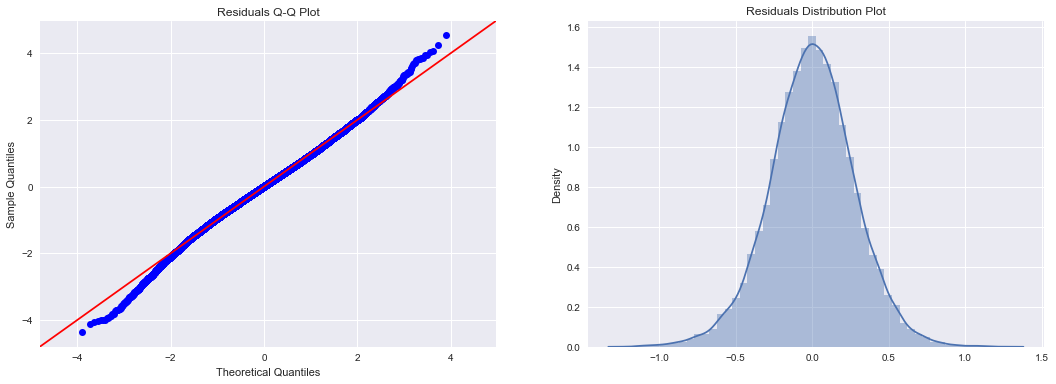

In [66]:
fig, axs = plt.subplots(ncols=2, figsize = (18,6))

residuals = model.resid
sm.graphics.qqplot(residuals, dist = stats.norm, line='45', fit=True, ax=axs[0])
axs[0].set_title('Residuals Q-Q Plot')
sns.distplot(residuals, ax=axs[1])
axs[1].set_title('Residuals Distribution Plot')

Text(0.5, 1.0, 'Residuals Scatterplot')

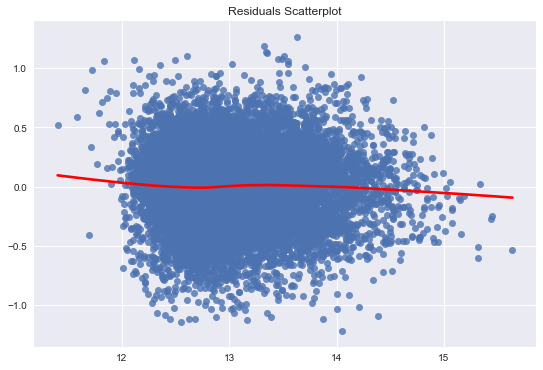

In [67]:
plt.figure(figsize=(9,6))
sns.regplot(x=model.predict(), y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals Scatterplot')

#### Plot predictions for the training and test sets against the actual data:

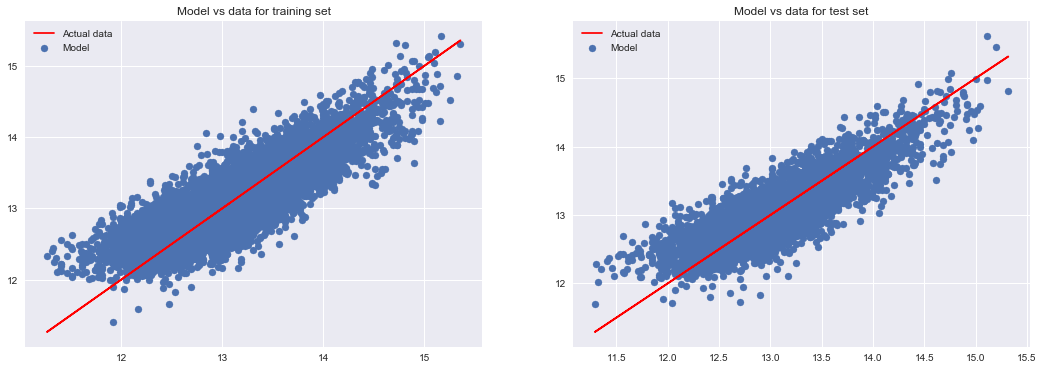

In [49]:
fig, axs = plt.subplots(ncols=2, figsize = (18,6))

#Train set
axs[0].scatter(y_train, y_hat_train, label='Model')
axs[0].plot(y_train, y_train, label='Actual data', color='red')
axs[0].set_title('Model vs data for training set')
axs[0].legend();

# Test set
axs[1].scatter(y_test, y_hat_test, label='Model')
axs[1].plot(y_test, y_test, label='Actual data',  color='red')
axs[1].set_title('Model vs data for test set')
axs[1].legend();

### Calculate bias and variance

In [218]:
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

def bias(y, y_hat):
    return np.mean(y_hat - y)

In [219]:
# Bias and variance for training set 
b = bias(y_train, y_hat_train) 
v = variance(y_hat_train) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: -6.460616181311405e-17 
Train variance: 0.7174200043327994


In [220]:
# Bias and variance for test set 
b = bias(y_test, y_hat_test) 
v = variance(y_hat_test) 
print('Test bias: {} \nTest variance: {}'.format(b, v))

Test bias: -0.01053133908041892 
Test variance: 0.7625989736490899


### Prediction

In [174]:
house_address = input("What the address (i.e. '14003 NE 6th Pl, Bellevue, WA 98007'): ")
sqft_above = int(input("What's the squarefootage of the house: "))
bedrooms = int(input("How many bedrooms: "))
waterfront = int(input("Is the house waterfront (choose 0-1): "))
has_basement = int(input("Does the house has a basement (choose 0-1): "))

What the address (i.e. '14003 NE 6th Pl, Bellevue, WA 98007'):  14003 NE 6th Pl, Bellevue, WA 98007
What's the squarefootage of the house:  2000
How many bedrooms:  2
Is the house waterfront (choose 0-1):  1
Does the house has a basement (choose 0-1):  1


In [171]:
# house_address = '14003 NE 6th Pl, Bellevue, WA 98007'
# sqft_above = 2000
# bedrooms = 2
# waterfront = 1
# has_basement = 1

In [175]:
#Calculate distance from epicenter
address=house_address
geolocator = Nominatim(user_agent="Your_Name")
location = geolocator.geocode(address)
dist_epicenter=haversine(epicenter, [location.latitude, location.longitude], unit='km')

#Calculate zip_price_cat
zipcode = pd.to_numeric(location.address.split(', ')[-2], errors='coerce')
zip_price_cat = zip_cat_df[zip_cat_df['zipcode'] == zipcode]['zip_price_cat'].values

#Provide some random predictors
X_predictors = np.array([[has_basement,zip_price_cat,np.log(sqft_above),bedrooms,waterfront,np.log(dist_epicenter)]])

#Predict house price
yhat = linreg.predict(X_predictors)
print('Predicted house price is:')
print(np.expm1(yhat))

Predicted house price is:
[1574438.46979546]


In [88]:
# from geopy.geocoders import Nominatim

# address='294 Henry Street, Brooklyn, NY 11201'
# geolocator = Nominatim(user_agent="Your_Name")
# location = geolocator.geocode(address)
# print(location.address)
# print((location.latitude, location.longitude))
# #Barcelona, Barcelonès, Barcelona, Catalunya, 08001, España
# #(41.3828939, 2.1774322)